In [12]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
import plotly.subplots
import torch
from progiter import ProgIter

from IPython.utils import io

from src.prev.calibration import CalibrationMethod, calc_calibration_metrics, calibrate_logits_fast
from src.prev.data_loading import get_values, Kind, Split
from src.prev.plotting import plot_aggregate_results, Confidence, box_plot
from src.prev.scaling import scale_prevalences_ir

current_path = os.getcwd()
DATA_PATH = Path(current_path).parent / 'data'
RESULT_PATH = Path(current_path).parent / 'results'
assert DATA_PATH.exists() and RESULT_PATH.exists()
torch.manual_seed(seed=0)

In [3]:
all_tasks = ['lapgyn4_surgical_actions', 'lapgyn4_instrument_count', 'lapgyn4_anatomical_actions', 'nerthus_bowel_cleansing_quality', 'hyperkvasir_therapeutic-interventions', 'cholec80_grasper_presence', 'cholec80_hook_presence', 'idle_action_recognition', 'brain_tumor_classification', 'brain_tumor_type_classification', 'chexpert_enlarged_cardiomediastinum', 'chexpert_cardiomegaly', 'chexpert_edema', 'chexpert_consolidation', 'chexpert_pneumonia', 'chexpert_pneumothorax', 'chexpert_pleural_effusion', 'chexpert_fracture', 'pneumonia_classification', 'covid_xray_classification', 'deep_drid_dr_level', 'deep_drid_quality', 'kvasir_capsule_anatomy', 'mura_xr_wrist', 'mura_xr_shoulder', 'mura_xr_humerus', 'mura_xr_hand', 'mura_xr_forearm', 'mura_xr_finger', 'mura_xr_elbow']
data = {}
for t in ProgIter(all_tasks, desc='Loading data'):
    data[t] = get_values(t, DATA_PATH, proj='mic23_predictions_original_0')  # original paper predictions
    # data[t] = get_values(t, DATA_PATH, proj='mic23_predictions_reproduce_0')  # additional seed experiment

Loading data 100.00% 30/30... rate=4.55 Hz, eta=0:00:00, total=0:00:06


In [13]:
# Research Question: How does calibration deteriorate with increasing imbalance ratio
calibration_ir_results = []
IRS = list(np.arange(1, 10.5, 0.5))
for cal_method in ProgIter(list(CalibrationMethod)[:]):
    for ir in IRS:
        # do the calibration on all tasks
        calibrated_test_data: Dict[str, Dict[Kind, Dict[Split, torch.Tensor]]] = {}
        for t in all_tasks:
            # modify DEV_TEST according to IR
            try:
                app_test_logits, app_test_classes = scale_prevalences_ir(logits=data[t][Kind.LOGITS][Split.APP_TEST],
                                                                         classes=data[t][Kind.LABELS][Split.APP_TEST],
                                                                         ir=ir)
            except:
                print(f'{t=}, {ir=}')
                raise
            prior = None
            if cal_method in [CalibrationMethod.AFFINE_REWEIGHTED, CalibrationMethod.TEMPERATURE_SCALING_REWEIGHTED]:
                # adapt prevalences from DEV_CAL to APP_TEST
                prior = torch.bincount(app_test_classes)
                # scaling for convergence stability
                prior = prior / prior.sum()
            mod_data = {Kind.LOGITS: {Split.DEV_CAL: data[t][Kind.LOGITS][Split.DEV_CAL],
                                      Split.DEV_TEST: data[t][Kind.LOGITS][Split.DEV_TEST],
                                      Split.APP_TEST: app_test_logits},
                        Kind.LABELS: {Split.DEV_CAL: data[t][Kind.LABELS][Split.DEV_CAL],
                                      Split.DEV_TEST: data[t][Kind.LABELS][Split.DEV_TEST],
                                      Split.APP_TEST: app_test_classes}}
            if 'ESTIMATED' in cal_method.name:
                if cal_method == CalibrationMethod.AFFINE_ESTIMATED_005:
                    std = 0.05
                elif cal_method == CalibrationMethod.AFFINE_ESTIMATED_0075:
                    std = 0.075
                elif cal_method == CalibrationMethod.AFFINE_ESTIMATED_01:
                    std = 0.1
                else:
                    std = 0.025
            else:
                std = None
            try:
                calibrated_logits = calibrate_logits_fast(data=mod_data,
                                                          calibration=cal_method, prior=prior, std=std)
            except RuntimeError:
                print(t)
                raise
            # suppress plotting from the metrics reloaded
            with io.capture_output():
                dev_metrics = calc_calibration_metrics(logits=calibrated_logits[Split.DEV_TEST],
                                                   labels=data[t][Kind.LABELS][Split.DEV_TEST])
                app_metrics = calc_calibration_metrics(logits=calibrated_logits[Split.APP_TEST],
                                                   labels=app_test_classes)
            # going from dev to test
            diff_metrics = {m: app_metrics[m] - dev_metrics[m] for m in dev_metrics}
            _info = {'calibration': cal_method.name, 'ir': ir, 'task': t}
            _info.update({f'dev_{m}': v for m, v in dev_metrics.items()})
            _info.update({f'app_{m}': v for m, v in app_metrics.items()})
            _info.update({f'diff_{m}': v for m, v in diff_metrics.items()})
            calibration_ir_results.append(_info)
            # plot calibration curves (binary tasks only, DEV_TEST visualization)
ir_df = pd.DataFrame(calibration_ir_results)
ir_df.to_csv(RESULT_PATH / 'calibration_results_app_test.csv')

 100.00% 10/10... rate=0.10 Hz, eta=0:00:00, total=0:01:44


In [7]:
# plotting (if results are already stored)
p = RESULT_PATH / 'calibration_results_app_test.csv'
DELTA = False

plot_methods_main = [m for m in CalibrationMethod if 'ESTIMATED' not in m.name]
plot_methods_supp = [CalibrationMethod.NONE, CalibrationMethod.AFFINE_REWEIGHTED, CalibrationMethod.AFFINE_ESTIMATED_005,
                     CalibrationMethod.AFFINE_ESTIMATED_0075, CalibrationMethod.AFFINE_ESTIMATED_01]
if p.exists():
    ir_df = pd.read_csv(p)
    for metric in ['rbs', 'cwce', 'bs', 'nbs']:
        for variant, plot_methods in zip(['main', 'supp'], [plot_methods_main, plot_methods_supp]):
            if variant == 'main':
                bound = {'rbs': None, 'bs': None, 'nbs': None,'cwce': None}[metric]
            else: bound = None
            plots_base_path = RESULT_PATH / f'calibration_deterioration_{metric}_{DELTA}_{variant}'
            fig = plotly.subplots.make_subplots(rows=1, cols=2,
                                                y_title=f'<b>{metric.upper()}</b>',
                                                horizontal_spacing=0.04,
                                                shared_yaxes=True)
            fig.update_layout(template='plotly')
            # first generate the data for the line plot
            def line_values_extraction_func(results_df, line_identifier, delta):
                _col = f'diff_{metric}' if delta else f'app_{metric}'
                _df = results_df[results_df['calibration'] == line_identifier.name][['task', 'ir', _col]]
                _df = _df.pivot(index='task', columns='ir', values=_col)
                _df = _df.abs()
                return _df.values

            line_fig_data = plot_aggregate_results(info_df=ir_df, line_ids=plot_methods,
                                                   file=plots_base_path,
                                                   line_values_extraction_func=line_values_extraction_func,
                                                   bound=bound,
                                                   ci=Confidence.STD,
                                                   y_axis_title=metric.upper(),
                                                   # font_size=30
                                                   ).data
            # build line plot into fig
            for elem in line_fig_data:
                elem['showlegend'] = False
                fig.add_trace(elem, row=1, col=1)
            # generate box plot and pass into fig
            _col = f'diff_{metric}' if DELTA else f'app_{metric}'
            _df = ir_df[ir_df['ir'] == 10.0][[_col, 'calibration', 'task']]
            _df = _df.pivot(index='task', columns='calibration', values=_col)
            box_fig_data = box_plot(
                df=_df.rename(columns={cal.name: cal.value for cal in CalibrationMethod}),
                line_ids=plot_methods).data
            for elem in box_fig_data:
                fig.add_trace(elem, row=1, col=2)
            # layout stuff
            fig.update_layout(autosize=False, width=1800, height=500, legend={"font": {"size": 30}, "itemsizing": 'constant'})
            # fix distances
            fig.update_layout(margin=dict(t=0, b=0))
            fig['layout']['xaxis']['title'] = "<b>Imbalance ratio</b>"
            fig['layout']['yaxis']['range'] = bound
            fig['layout']['font']['size'] = 20
            for i in fig['layout']['annotations']:
                i['font'] = dict(size=30)
            fig['layout']['font']['family'] = "NewComputerModern10"
            joint_path = plots_base_path.parent / (plots_base_path.name + '_joint')
            fig.write_image(joint_path.with_suffix(suffix='.eps'))
            fig.write_image(joint_path.with_suffix(suffix='.png'))
            fig.write_html(joint_path.with_suffix(suffix='.html'))

## Figure 3

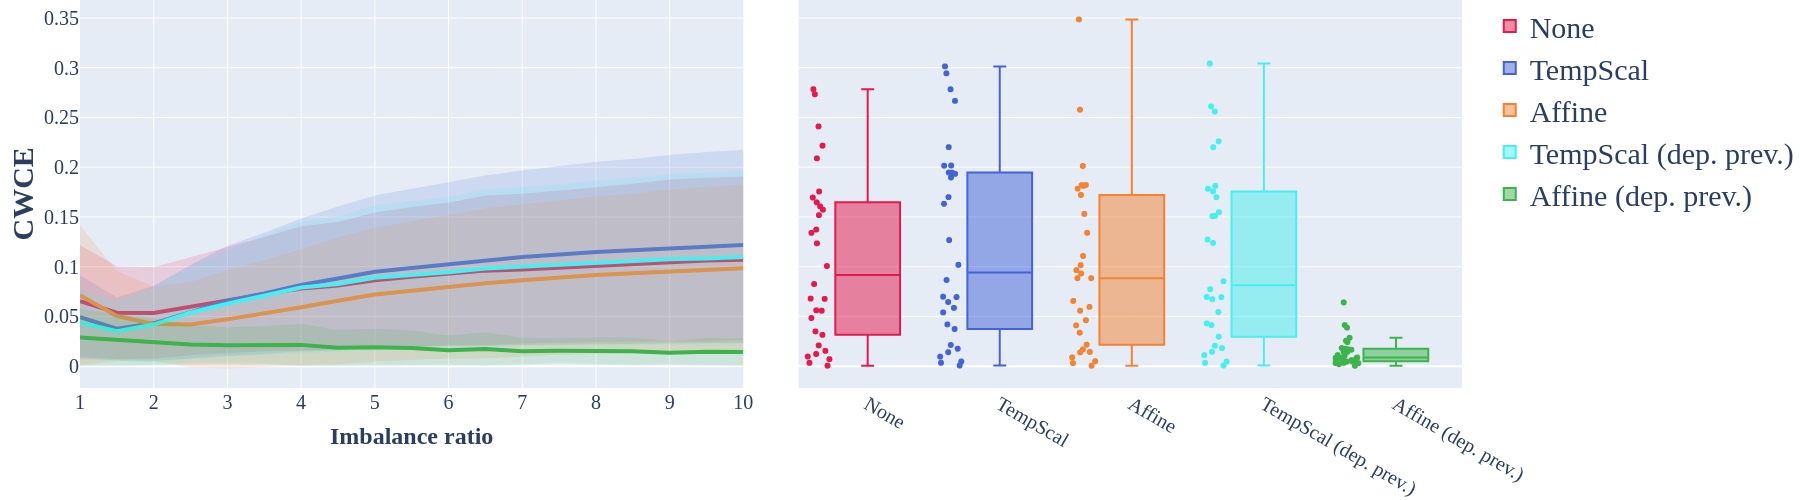

In [5]:
from IPython import display

display.Image(RESULT_PATH / 'calibration_deterioration_cwce_False_main_joint.png')

## Figure 6

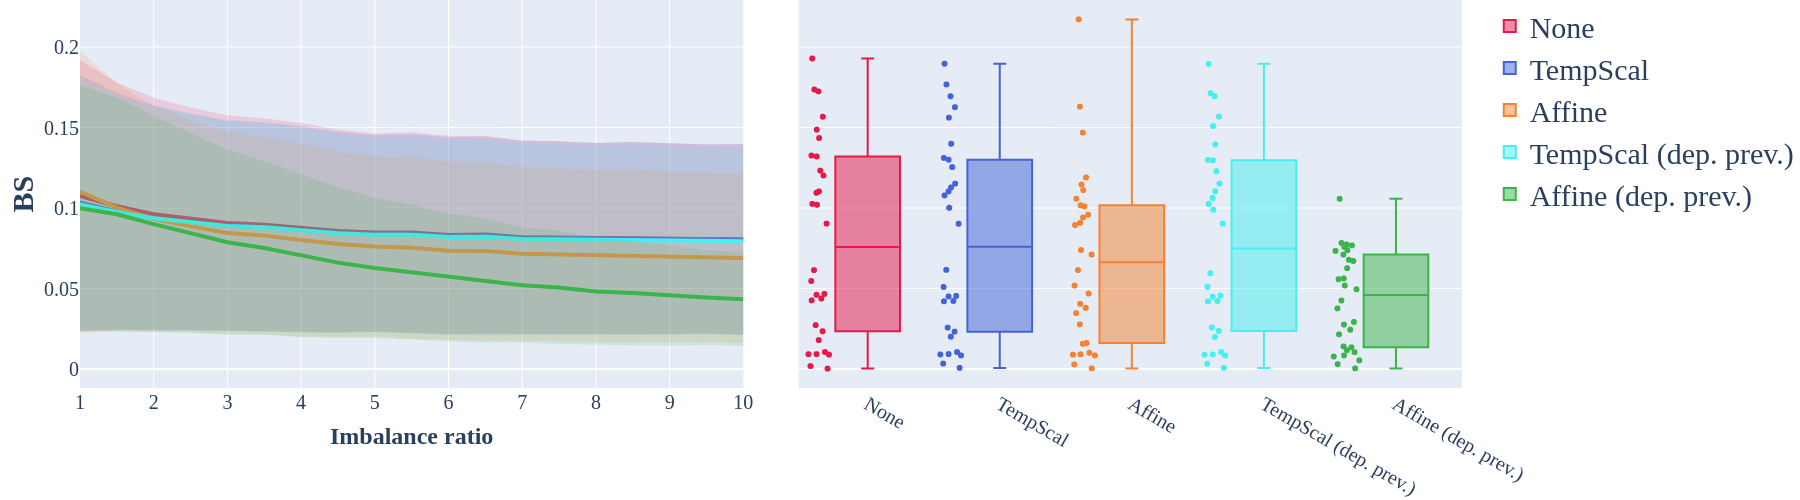

In [6]:
display.Image(RESULT_PATH / 'calibration_deterioration_bs_False_main_joint.png')

## Figure 7

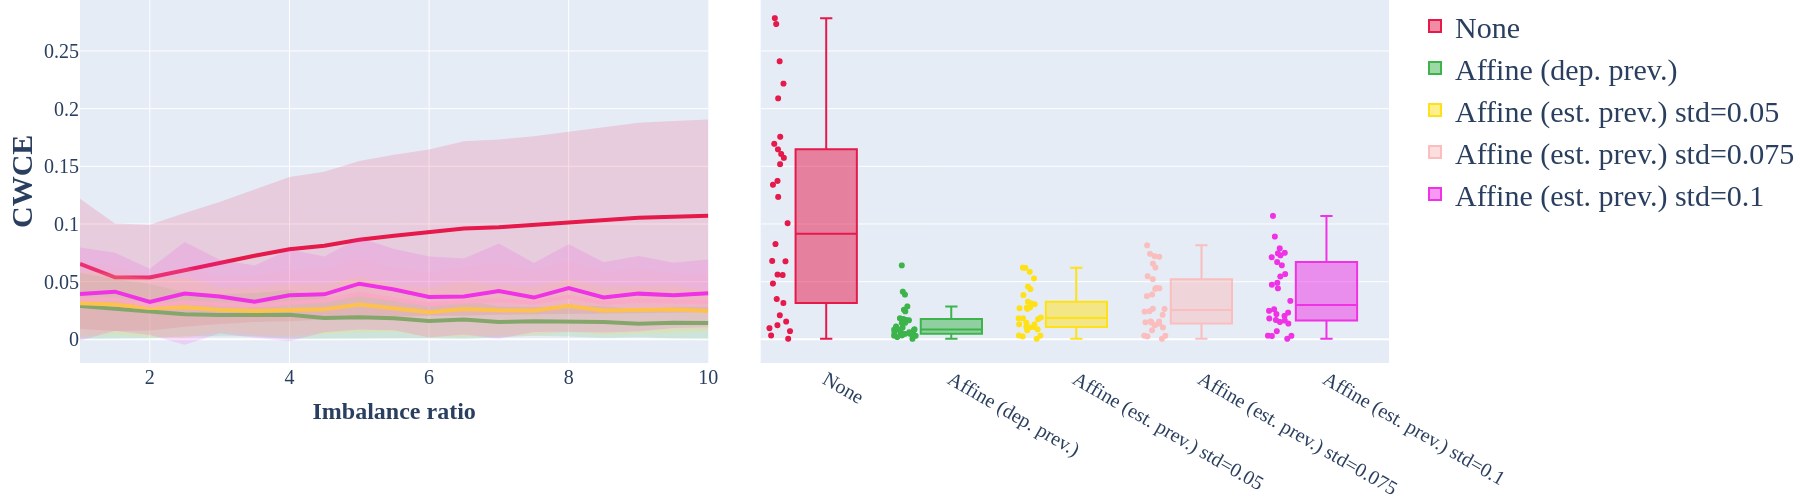

In [7]:
display.Image(RESULT_PATH / 'calibration_deterioration_cwce_False_supp_joint.png')